[原版（英文）图书地址](https://www.oreilly.com/library/view/feature-engineering-for/9781491953235/)

**翻译**：[apachecn](https://github.com/apachecn)，[翻译版本地址](https://github.com/apachecn/feature-engineering-for-ml-zh)

**代码修改和整理**：[黄海广](https://github.com/fengdu78)，原文修改成jupyter notebook格式，并增加和修改了部分代码，测试全部通过，所有数据集已经放在[百度云](data/README.md)下载。

# 八、自动化特征提取器：图像特征提取和深度学习

> 译者：[@friedhelm739](https://github.com/friedhelm739)

视觉和声音是人类固有的感觉输入。我们的大脑是可以迅速进化我们的能力来处理视觉和听觉信号的，一些系统甚至在出生前就对刺激做出反应。另一方面，语言技能是学习得来的。他们需要几个月或几年的时间来掌握。许多人天生就具有视力和听力的天赋，但是我们所有人都必须有意训练我们的大脑去理解和使用语言。

有趣的是，机器学习的情况是相反的。我们已经在文本分析应用方面取得了比图像或音频更多的进展。以搜索问题为例。人们在信息检索和文本检索方面已经取得了相当多年的成功，而图像和音频搜索仍在不断完善。在过去五年中，深度学习模式的突破最终预示着期待已久的图像和语音分析的革命。

进展的困难与从相应类型的数据中提取有意义特征的困难直接相关。机器学习模型需要语义上有意义的特征进行语义意义的预测。在文本分析中，特别是对于英语这样的语言，其中一个基本的语义单位（一个词）很容易提取，可以很快地取得进展。另一方面，图像和音频被记录为数字像素或波形。图像中的单个“原子”是像素。在音频数据中，它是波形强度的单一测量。它们包含的语义信息远少于数据文本。因此，在图像和音频上的特征提取和工程任务比文本更具挑战性。

在过去的二十年中，计算机视觉研究已经集中在人工标定上，用于提取良好的图像特征。在一段时间内，图像特征提取器，如 SIFT 和 HOG 是标准步骤。深度学习研究的最新发展已经扩展了传统机器学习模型的范围，将自动特征提取作为基础层。他们本质上取代手动定义的特征图像提取器与手动定义的模型，自动学习和提取特征。人工标定仍然存在，只是进一步深入到建模中去。

在本章中，我们将从流行的图像特征提取SIFT和HOG入手，深入研究本书所涵盖的最复杂的建模机制：深度学习的特征工程。

## 最简单的图像特征（为什么他们不好使）

从图像中提取的哪些特征是正确的呢？答案当然取决于我们试图用这些特征来做什么。假设我们的任务是图像检索：我们得到一张图片并要求从图像数据库中得到相似的图片。我们需要决定如何表示每个图像，以及如何测量它们之间的差异。我们可以看看图像中不同颜色的百分比吗？图8-1展示了两幅具有大致相同颜色轮廓但有着非常不同含义的图片；一个看起来像蓝色天空中的白云，另一个是希腊国旗。因此，颜色信息可能不足以表征图像。

![图8-1](images/chapter8/8-1.png)

另一个比较简单的想法是测量图像之间的像素值差异。首先，调整图像的宽度和高度。每个图像由像素值矩阵表示。矩阵可以通过一行或一列被堆叠成一个长向量。每个像素的颜色（例如，颜色的 RGB 编码）现在是图像的特征。最后，测量长像素向量之间的欧几里得距离。这绝对可以区分希腊国旗和白云。但作为相似性度量，它过于严格。云可以呈现一千种不同的形状，仍然是一朵云。它可以移动到图像的一边，或者一半可能位于阴影中。所有这些转换都会增加欧几里得距离，但是他们不应该改变图片仍然是云的事实。

问题是单个像素不携带足够的图像语义信息。因此，使用它们用于分析结果是非常糟糕的。在 1999 年，计算机视觉研究者想出了一种更好的方法来使用图像的统计数据来表示图像。它叫做 Scale Invariant Feature Transform（SIFT）。

SIFT最初是为对象识别的任务而开发的，它不仅涉及将图像正确地标记为包含对象，而且确定其在图像中的位置。该过程包括在可能的尺度金字塔上分析图像，检测可以指示对象存在的兴趣点，提取关于兴趣点的特征（通常称为计算机视觉中的图像描述符），并确定对象的姿态。

多年来，SIFT 的使用扩展到不仅提取兴趣点，而且遍及整个图像的特征。SIFT 特征提取过程非常类似于另一种称为 Histogram of Oriented Gradients （HOG）的技术。它们都计算梯度方向的直方图。现在我们详细地描述一下。

## 人工特征提取：SIFT 与 HOG

### 图像梯度

要比原始像素值做得更好，我们必须以某种方式将像素组织成更多信息单元。相邻像素之间的差异通常是非常有用的特征。通常情况下像素值在对象的边界处是不同，当存在阴影、图案内或纹理表面时。相邻像素之间的差值称为图像梯度。

计算图像梯度的最简单的方法是分别计算图像沿水平（$X$）和垂直（$Y$）轴的差异，然后将它们合成为二维矢量。这涉及两个 1D 差分操作，可以用矢量掩模或滤波器方便地表示。掩码$(1, 0, -1)$可以得到在左像素和右像素之间的差异或者上像素和下像素之间的差异，取决于我们应用掩码的方向。当然也有二维梯度滤波器。但在本例中，1D 滤波器就足够了。

为了对图像应用滤波器，我们执行卷积。它涉及翻转滤波器和内积与一小部分的图像，然后移动到下一个块。卷积在信号处理中很常见。我们将使用`*`来表示操作：

$$
[a\quad b\quad c]*[1\quad 2\quad 3]=c*1+b*2+a*3
$$

在像素点$(i,j)$的$x$梯度和$y$梯度为：
$$
g_{x}(i, j)=[1\quad 0\quad -1]*[I(i-1,j)\quad I(i,j)\quad I(i+1,j)]=-1*I(i-1,j)+1 * I(i + 1,j)
$$
$$
g_{y}(i, j)=[1\quad 0\quad -1]*[I(i,j-1)\quad I(i,j)\quad I(i,j+1)]=-1*I(i,j-1)+1 * I(i ,j+ 1)
$$

他们一起组成了梯度：

$$
\nabla I(i, j)=\left[\begin{array}{l}{g_{x}(i, j)} \\ {g_{y}(i, j)}\end{array}\right]
$$

向量可以通过它的方向和大小来完全描述。梯度的大小等于梯度的欧几里得范数，这表明像素值在像素周围变化得多大。梯度的位置或方向取决于水平方向和垂直方向上的变化的相对大小；图 8-2 说明了这些数学概念。

![图8-2](images/chapter8/8-2.png)
<center>图 8-2</center>


图8—3展出了由垂直和水平梯度组成的图像梯度的示例。每个示例是一个 9 像素的图像。每个像素用灰度值标记。（较小的数字对应于较深的颜色）中心像素的梯度显示在每个图像下面。左侧的图像包含水平条纹，其中颜色仅垂直变化。因此，水平梯度为零，梯度垂直为非零。中心图像包含垂直条纹，因此水平梯度为零。右边的图像包含对角线条纹，斜率也是对角线。

![图8-3](images/chapter8/8-3.png)
<center>图 8-3</center>

它们能在真实的图像上发挥作用吗？在例 8-1 中，我们使用图 8-4 所示的猫的水平和垂直梯度上来实验。由于梯度是在原始图像的每个像素位置计算的，所以我们得到两个新的矩阵，每个矩阵可以被可视化为图像。

![图8-4](images/chapter8/8-4.png)
<center>图 8-4</center>

### 例 8-1

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.feature import hog
from skimage import data, color, exposure

In [2]:
image = color.rgb2gray(data.chelsea())

In [3]:
fd, hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(1, 1),
    visualise=True)

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


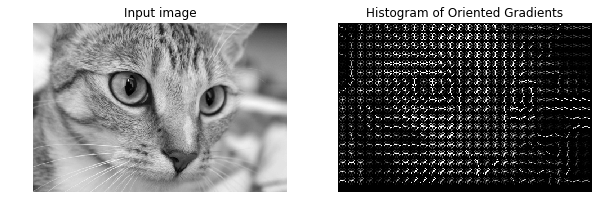

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax2.set_adjustable('box-forced')

注意，水平梯度提取出强烈的垂直模式，如猫眼睛的内边缘，而垂直梯度则提取强的水平模式，如晶须和眼睛的上下眼睑。这乍看起来似乎有些矛盾，如果我们仔细考虑一下，这还是有道理的。水平（$X$）梯度识别水平方向上的变化。强的垂直图案在大致相同的$X$位置上跨越多个$Y$像素。因此，垂直图案导致像素值的水平差异。这也是我们的眼睛也能察觉到的。

In [6]:
import numpy as np

In [7]:
gx = np.empty(image.shape, dtype=np.double)
gx[:, 0] = 0
gx[:, -1] = 0
gx[:, 1:-1] = image[:, :-2] - image[:, 2:]
gy = np.empty(image.shape, dtype=np.double)
gy[0, :] = 0
gy[-1, :] = 0
gy[1:-1, :] = image[:-2, :] - image[2:, :]

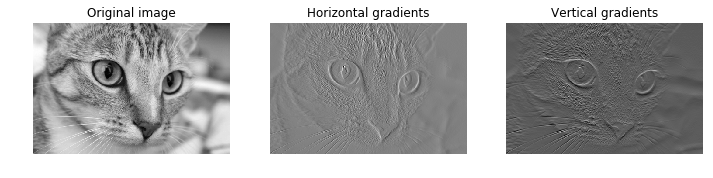

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3, figsize=(12, 8), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Original image')
ax1.set_adjustable('box-forced')

ax2.axis('off')
ax2.imshow(gx, cmap=plt.cm.gray)
ax2.set_title('Horizontal gradients')
ax2.set_adjustable('box-forced')

ax3.axis('off')
ax3.imshow(gy, cmap=plt.cm.gray)
ax3.set_title('Vertical gradients')
ax3.set_adjustable('box-forced')

## 梯度方向直方图

单个图像梯度可以识别图像邻域中的微小差异。但是我们的眼睛看到的图案比那更大。例如，我们看到一整只猫的胡须，而不仅仅是一个小部分。人类视觉系统识别区域中的连续模式。因此，我们咋就图像梯度邻域有仍然有很多的工作要做。

我们如何精确地归纳向量？统计学家会回答：“看分布！SIFT 和 HOG 都走这条路。它们计算（正则化）梯度矢量直方图作为图像特征。直方图将数据分成容器并计算每容器中有多少，这是一个（不规范的）经验分布。规范化确保数和为 1，用数学语言描述为它具有单位 L 范数。

图像梯度是矢量，矢量可以由两个分量来表示：方向和幅度。因此，我们仍然需要决定如何设计直方图来表示这两个分量。SIFT 和 HOG 提供了一个解决方案，其中图像梯度被它们的方向角所包括，由每个梯度的大小加权。以下是流程：

1.  将 0° - 360° 分成相等大小的容器。

2.  对于邻域中的每个像素，将权重$W$添加到对应于其方向角的容器中。

3.  $W$是梯度的大小和其他相关信息的函数。例如，其他相关信息可以是像素到图像贴片中心的逆距离。其思想是，如果梯度较大，权重应该很大，而图像邻域中心附近的像素比远离像素的像素更大。

4.  正则化直方图。

图 8-5 提供了由`4x4`像素的图像邻域构成的8个容器的梯度方向直方图的图示。

![图8-5](images/chapter8/8-5.png)

当然，在基本的梯度方向直方图算法中还有许多选项。像通常一样，正确的设置可能高度依赖于想要分析的特定图像。

### 有多少容器？

他们的跨度是从 0° - 360°（有符号梯度）还是 0° - 180°（无符号梯度）？

具有更多的容器导致梯度方向的细粒度量化，因此会保留更多关于原始梯度的信息。但是，有太多的容器是不必要的，并可能导致过度拟合训练数据。例如，在图像中识别猫可能不依赖于精确地取向在 3° 的猫的晶须。

还有一个问题，容器是否应该跨越 0 - 360°，这将沿$Y$轴保持梯度，或跨越 0°- 180°，这将不会保留垂直梯度的符号。Dalal 与 Triggs 是 HOG 论文的最初作者，实验确定从 0 - 180° 跨越的 9 个容器是最好的，而 SIFT 论文推荐了 8 个跨越 0° - 360° 的容器。

### 使用什么样的权重函数？

HOG 论文比较各种梯度幅度加权方案：其大小本身、平方、平方根、二值化等等。没有改变的平面大小在实验中表现最好。

SIFT 还使用梯度的原始大小。最重要的是，它希望避免图像描述符在图像窗口位置的微小变化中的突然变化。因此，它使用从窗口中心测量的高斯距离函数来衡量来自邻域边缘的梯度。换言之，梯度幅值乘以高斯函数 $\frac{1}{2 \pi \sigma^{2}} e^{-\left\|p-p_{0}\right\|^{2} / 2 \sigma^{2}}$，其中$P$是产生梯度的像素的位置，$P0$图像邻域的中心位置，并且$\sigma$为高斯的宽度，$\sigma$被设置为邻域半径的一半。

SIFT 还希望避免从单个图像梯度方向的微小变化来改变方向直方图中的大的变化。因此，它使用一个插值技巧，将权重从一个梯度扩展到相邻的方向箱。特别地，根箱（梯度分配的箱）得到加权幅度的 1 倍的投票。每个相邻的容器得到 1-D 的投票，其中$D$是来自根容器的直方图箱单元的差异。

总的来说，SIFT 的单一图像梯度的投票是

$w_{(\nabla p, b)}=w_{b} \sigma\left\|\nabla_{p}\right\|$

其中 $\nabla_{p}$ 是在箱$b$的像素点$p$的梯度，$Wb$是权值$b$的插值，$\sigma$是$p$距离中心的高斯距离。

### 邻域怎么定义？他们应该怎样覆盖图片？

HOG 和 SIFT 都基于图像邻域的两层表示：首先，将相邻像素组织成单元，然后将相邻单元组织成块。计算每个单元的方向直方图，并将单元直方图矢量连接起来，形成整个块的最终特征描述符。

SIFT 使用`16x16`像素的单元，将其组织成 8 个方向的容器，然后通过`4x4`单元的块分组，使得图像邻域的`4x4x8=128`个特征。

HOG 论文实验用矩形和圆形形状的单元和块。矩形单元称为 R-HOG。最好的 R-HOG 设置为`8x8`像素的 9 个定向仓，每个分组为`2x2`个单元的块。圆形窗口称为 C-HOG，具有由中心单元的半径确定的变量、单元是否径向分裂、外单元的宽度等。

无论邻域如何组织，它们通常重叠形成整个图像的特征向量。换言之，单元和块在水平方向和垂直方向上横移图像，一次只有几个像素，以覆盖整个图像。

邻域结构的主要组成部分是多层次的组织和重叠的窗口，其在图像上移动。在深度学习网络的设计中使用了相同的成分。

### 什么样的归一化？

归一化处理出特征描述符，使得它们具有可比的大小。它是缩放的同义词，我们在第 4 章中讨论过。我们发现，文本特征的特征缩放（以 tf-idf 的形式）对分类精度没有很大影响。图像特征与文字区别很大，其对在自然图像中出现的照明和对比度的变化可能是非常敏感的。例如，在强烈的聚光灯下观察苹果的图像，而不是透过窗户发出柔和的散射光。即使物体是相同的，图像梯度也会有非常不同的幅度。为此，计算机视觉中的图像特征通常从全局颜色归一化开始，以消除照度和对比度方差。对于 SIFT 和 HOG 来说，结果表明，只要我们对特征进行归一化，这种预处理是不必要的。

SIFT 遵循归一化-阈值-归一化方案。首先，块特征向量归一化为单位长度（L2 标准化）。然后，将特征剪辑除以最大值以摆脱极端的照明效果，如从相机的色彩饱和度。最后，将剪切特征再次归一化到单位长度。

HOG 论文实验涉及不同的归一化方案例如 L1 和 L2，包括 SIFT 论文中标归一化-阈值-归一化方案。他们发现L1归一化比其他的方法稍显不靠谱。

## SIFT 结构

SIFT 需要相当多的步骤。HOG 稍微简单，但是遵循许多相同的基本步骤，如梯度直方图和归一化。图 8-6 展示了 SIFT 体系结构。从原始图像中的感兴趣区域开始，首先将区域划分为网格。然后将每个网格单元进一步划分为子网格。每个子网格元素包含多个像素，并且每个像素产生梯度。每个子网格元素产生加权梯度估计，其中权重被选择以使得子网格元素之外的梯度可以贡献。然后将这些梯度估计聚合成子网格的方向直方图，其中梯度可以具有如上所述的加权投票。然后将每个子网格的方向直方图连接起来，形成整个网格的长梯度方向直方图。（如果网格被划分为`2x2`子网格，那么将有 4 个梯度方向直方图拼接成一个。）这是网格的特征向量。从这开始，它经过一个归一化-阈值-归一化过程。首先，将向量归一化为单位范数。然后，将单个值剪辑除以最大阈值。最后，再次对阈值向量进行归一化处理。这是图像块的最终 SIFT 特征描述。

![图8-6](images/chapter8/8-6.png)

## 基于深度神经网络的图像特征提取

SIFT 和 HOG 在定义良好的图像特征方面走了很久。然而，计算机视觉的最新成果来自一个非常不同的方向：深度神经网络模型。这一突破发生在 2012 的 ImageNet 挑战中，多伦多大学的一组研究人员几乎将前一年的获奖者的错误率减半。他们强调他们的方法是“深度学习”。与以前的神经网络模型不同，最新一代包含许多层叠在彼此之上的神经网络层和变换。ImageNet 2012 的获奖模型随后被称为 AlexNet ，其神经网络有 13 层。之后 ImageNet 2014 的获胜者有 27 层。

从表面上看，叠层神经网络的机制与 SIFT 和 HOG 的图像梯度直方图有很大的不同。但是 AlxNETA 的可视化显示，前几层本质上是计算边缘梯度和其他简单的操作，很像 SIFT 和 HOG。随后的层将局部模式组合成更全局的模式。最终的结果是一个比以前更强大的特征提取器。

堆叠层的神经网络（或任何其他分类模型）的基础思想不是新的。但是，训练这种复杂的模型需要大量的数据和强大的计算能力，这是直到最近才有的。ImageNet 数据集包含来自 1000 个类的 120 万个图像的标记集。现代 GPU 加速了矩阵向量计算，这是许多机器学习模型的核心，包括神经网络。深度学习方法的成功取决于大量可用的数据和大量的 GPU 小时。

深度学习架构可以由若干类型的层组成。例如，AlxNETs 包含卷积、全连接层、归一化层和最大池化层。现在我们将依次查看每一层的内容。

## 全连接层

所有神经网络的核心是输入的线性函数。我们在第4章中遇到的逻辑回归是神经网络的一个示例。全连接的神经网络只是所有输入特征的一组线性函数。回想一个线性函数可以被写为输入特征向量与权重向量之间的内积，加上一个可能的常数项。线性函数的集合可以表示为矩阵向量乘积，其中权重向量成为权重矩阵。

### 全连接层的数学定义

$$
z=Wx+b
$$

$W$的每一行是将整个输入向量$X$映射成$Z$中的单个输出的权重向量。$b$是表示每个神经元恒定偏移（或偏置）的标量。

全连接层之所以如此命名，是因为在每一个输入都要在每个输出中使用。在数学上，这意味着对矩阵$W$中的值没有限制。（如我们将很快看到的，卷积层仅利用每个输出的一小部分输入。）在图中，一个完全连接的神经网络可以由一个完整的二部图表示，其中前一层的每个结点输出都连接到下一层的每个输入。

![图8-7](images/chapter8/8-7.png)

全连接层包含尽可能多的参数。因此，它们是昂贵的。这种密集连接允许网络检测可能涉及所有输入的全局模式。由于这个原因，AlexNet 的最后两层完全连接。在输入为条件下输出仍然是相互独立的。

## 卷积层

与全连接层相反，卷积层仅使用每个输出的输入子集。通过在输入上移动窗，每次使用几个特征产生输出。为了简单起见，可以对输入的不同集合使用相同的权重，而不是重新学习新权重。数学上，卷积算子以两个函数作为输入，并产生一个函数作为输出。它翻转一个输入函数，将其移动到另一个函数上，并在每个点上在乘法曲线下输出总面积。计算曲线下总面积的方法是取其积分。操作符在输入中是对称的，这意味着不管我们翻转第一个输入还是第二个输入，输出都是一样的。

卷积定义为

$$
\left(f^{*} g\right)(t)=\int_{-\infty}^{\infty} f(\tau) g(t-\tau) d \tau=\int_{-\infty}^{\infty} g(\tau) f(t-\tau) d \tau
$$

我们已经看到了一个简单的卷积的示例，当我们看着图像梯度（“图像梯度”）。但是卷积的数学定义似乎仍有点复杂。用信号处理的示例来解释卷积后的结果是最容易的。

想象一下，我们有一个小黑匣子。为了看到黑匣子的作用，我们通过一个单一的刺激单位。无论输出看起来如何，我们记录在一张纸上。我们等到对最初的刺激没有反应为止。随时间变化的函数称为响应函数；我们称之为响应函数$g(t)$。

想想一下现在我们有一个疯狂的函数$f(t)$，随后将它输入黑盒中。在时间$t=0$时，$f(0)$与黑盒进行通讯，随后用$f(0)$乘以$g(0)$。在时间$t=1$，$f(1)$进入黑盒，随后与$g(0$相乘。在相同的时间，黑盒持续回复信号$f(0)$，它现在是与$g(1)$相乘了。所以在$t=1$时的输出为$(f(0)*g(1))+(f(1)*g(0))$。在$t=2$时，输出会变得更复杂，当$f(2)$进入图片后，这时$f(0)$与$f(1)$持续产生回复。所以在$t=2$时的总输出为$(f(0)*g(2))+(f(1)*g(1))+(f(2)*g(0))$。通过这种方式，响应函数在时间上有效地被翻转，其中$\tau=0$总是与当前进入黑匣子的信息进行交互，并且响应函数的尾部与先前发生的函数进行交互。图 8—8 展示了这一过程。到目前为止，为了便于描述，我们已经把时间离散了。在现实中，时间是连续的，所以总和是一个积分。

这个黑箱被称为线性系统，因为它不比标量乘法和求和更疯狂。卷积算子清楚地捕捉线性系统的影响。

### 卷积的思想

卷积算子捕获线性系统的效果，该线性系统将输入信号与其响应函数相乘，求出所有过去输入响应的和。

在上面的示例中，$g(t)$用来表示响应函数，$f(t)$表示输入。但是由于卷积是对称的，响应和输出实际上并不重要。输出只是两者的结合。$g(t)$也称为滤波器。

![图8-8](images/chapter8/8-8.png)

图像是二维信号，所以我们需要一个二维滤波器。二维卷积滤波器通过取两个变量的积分来推广一维情形。由于数字图像具有离散像素，卷积积分变成离散和。此外，由于像素的数量是有限的，滤波函数只需要有限数量的元素。在图像处理中，二维卷积滤波器也被称为核或掩模。

2 维卷积的离散定义
$$
\left(f^{*} g\right)[i, j]=\sum_{u=0}^{m} \sum_{v=0}^{n} f[u, v] g[i-u, j-v]
$$


当将卷积滤波器应用于图像时，我们不需要定义一个覆盖整个图像的巨型滤波器。相反，只覆盖几个像素的滤波器就够了，并且在图像上应用相同的滤波器，并在在水平和垂直像素方向上移动。

因为在图像中使用相同的滤波器，所以我们只需要定义一组小的参数。权衡是滤波器只能在一个小像素邻域内吸收信息。换言之，卷积神经网络识别局部信息而不是全局信息。

### 卷积滤波器示例

在这个示例中，我们将高斯滤波器应用于图像。高斯函数在零附近形成光滑对称的图形。滤波器在附近函数值产生加权平均值。当应用于图像时，它具有模糊附近像素值的效果。二维高斯滤波器是由 $G(x, y)=\frac{1}{2 \pi \sigma} e^{-\frac{x^{2}+y^{2}}{2 \sigma^{2}}}$ 定义的，其中$\sigma$为高斯函数的标准差，它控制着图形的宽度。

在下面的代码示例中，我们将首先创建二维高斯滤波器，然后将它与猫图像进行卷积以产生模糊的猫。注意，这不是计算高斯滤波器的最精确的方法，但它是最容易理解的。采取在每个离散点的加权平均值，而不是简单的点估计是更好的实现方法。

In [9]:
ind = [-1., -0.5, 0., 0.5, 1.]
X,Y = np.meshgrid(ind, ind)

In [10]:
X

array([[-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ]])

In [11]:
# G is the unnormalized Gaussian kernel where the value at (0,0) is 1.0
G = np.exp(-(np.multiply(X,X) + np.multiply(Y,Y))/2)
G

array([[0.36787944, 0.53526143, 0.60653066, 0.53526143, 0.36787944],
       [0.53526143, 0.77880078, 0.8824969 , 0.77880078, 0.53526143],
       [0.60653066, 0.8824969 , 1.        , 0.8824969 , 0.60653066],
       [0.53526143, 0.77880078, 0.8824969 , 0.77880078, 0.53526143],
       [0.36787944, 0.53526143, 0.60653066, 0.53526143, 0.36787944]])

In [12]:
from skimage import data, color
cat = color.rgb2gray(data.chelsea())

In [13]:
from scipy import signal
blurred_cat = signal.convolve2d(cat, G, mode='valid')

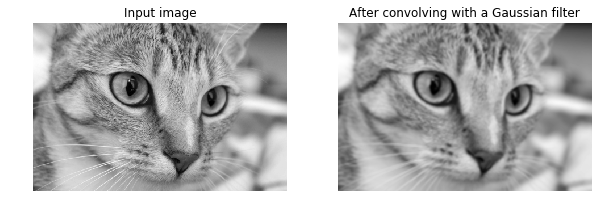

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(cat, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')

ax2.axis('off')
ax2.imshow(blurred_cat, cmap=plt.cm.gray)
ax2.set_title('After convolving with a Gaussian filter')
ax2.set_adjustable('box-forced')

AlxNet 中的卷积层是三维的。换言之，它们对前一层的三维像素进行操作。第一卷积神经网络采用原始 RGB 图像，并在所有三个颜色通道中学习用于局部图像邻域的卷积滤波器。随后的层跨越空间和内核尺寸将其作为输入像素。

## 线性整流函数（Relu）变换

神经网络的输出通常通过另一个非线性变换，也称为激活函数。常见的选择是 `tanh` 函数（在 -1 和 1 之间有界的光滑非线性函数），`sigmoid` 函数（0 到 1 之间的平滑非线性函数），或者称为整流线性单元的函数（`Relu`）。`Relu` 是一个线性函数的简单变化，其中负部分被归零。换言之，它修剪了负值，但留下无穷的正边界。`Relu` 的范围从 0 到无穷大。

整流线性单元（`Relu`）是线性函数，负部分归零。

$$RELU(x)=max(0,x)$$

`tanh` 函数，在 -1 和 1 之间有界的光滑非线性函数。

$$
\tanh (x)=\frac{\sinh (x)}{\cosh (x)}=\frac{e^{x}-e^{-x}}{e^{x}+e^{-x}}
$$

`sigmoid` 函数，0 到 1 之间的平滑非线性函数。

$$
\text { sigmoid }(x)=\frac{1}{1+e^{-x}}
$$

![图8-10](images/chapter8/8-10.png)

`Relu`变换对原始图像或高斯滤波器等非负函数没有影响。然而，经过训练的神经网络，无论是完全连接的还是卷积的，都有可能输出负值。AlxNet 使用 `Relu` 代替其他变换，在训练过程中可以更快的收敛，它适用于每一个卷积和全连接层。

## 响应归一化层

在第 4 章和本章之前的讨论之后，归一化对大家来说应该是一个熟悉的概念。归一化将个体输出通过集体总响应的函数来划分。因此，理解归一化的另一种方式是，它在邻居之间产生竞争，因为现在每个输出的强度都相对于其邻居进行测量。AlexNet 在不同内核的每个位置上归一化输出。

局部响应归一化引起相邻核之间的竞争

$$
y_{k}=x_{k} /\left(c+\alpha \sum_{\ell \in \text { neighborhood\ of } k} x_{\ell}^{2}\right)^{\beta}
$$

其中，$x_k$是第$k$个核的输出，$y_k$是相对于邻域中的其他核的归一化响应。对每个输出位置分别执行归一化。换言之，对于每个输出位置$(i,j)$，在附近的卷积核输出上进行归一化。注意，这与在图像邻域或输出位置上的归一化不相同。内核邻域的尺寸$c$、$\alpha$和$\beta$的大小超参数都是通过图像验证集调整的。

![图8-11](images/chapter8/8-11.png)

## 池化层

池化层将多个输入组合成单个输出。当卷积滤波器在图像上移动时，它为其尺寸下的每个邻域生成输出。池化层迫使局部图像邻域产生一个值而不是许多值。这减少了在深度学习网络的中间层中的输出数量，这有效地减少了过拟合训练数据的概率。

有多种方法汇集输入：平均，求和（或计算一个广义范数），或取最大值。池化层通过图像或中间输出层移动。Alexnet 使用最大池化层，以 2 像素（或输出）的步幅移动图像，并在 3 个邻居之间汇集。

![图8-12](images/chapter8/8-12.png)

## AlexNet 的结构

AlexNet 包含 5 个卷积层、2 个响应归一化层、3 个最大池化层和 2 个全连接层。与最终分类输出层一起，模型中共有 13 层神经网络层，形成8层层组。详情请参阅图 8-12。

输入图像首先被缩放到`256x256`像素。输入实际上是`224x224`大小的随机图像，具有 3 个颜色通道。前两个卷积层各有一个响应归一化层和一个最大池化层，最后一个卷积层接着是最大池化层。原始文件用两个 GPU 来分割训练数据和计算。层之间的通信主要限于在相同的 GPU 内。在层组 2 和 3 之间，并且在层组 5 之后是例外的。在这些边界点，下一层从两个 GPU 上的前一层的内核的像素作为输入。每个中间层都使用 `Relu` 变换。

![图8-13](images/chapter8/8-13.png)

![图8-14](images/chapter8/8-14.png)

注意 AlexNet 是 SIFT/HOG 特征提取器的梯度直方图标准化规范化体系结构（参见图8 -6），但具有更多的层。（这就是“深度学习”中的“深度”）不同于 SIFT/HOG，卷积核和全连接权值是从数据中学习的，而不是预定义的。此外，SIFT 中的归一化步骤在整个图像区域上遍及特征向量执行，而 AlexNet 中的响应归一化层在卷积核上归一化。

深入的来看，模型从局部图像邻域中提取特征开始。每个后续层建立在先前层的输出上，有效地覆盖原始图像的相继较大区域。因此，即使前五个卷积层都具有相当小的内核宽度，后面的层依然能够制定更多的全局特征。端部的全连接层是最具全局性的。

尽管特征的要点在概念上是清晰的，但是很难想象每个层挑选出的实际特征。图 8- 14 和图 8-15 显示了由特征型学习的前两层卷积核的可视化。第一层包括在不同的方向上的灰度边缘和纹理的检测器，以及颜色斑点和纹理。第二层似乎是各种光滑图案的检测器。

![图8-15](images/chapter8/8-15.png)

![图8-16](images/chapter8/8-16.png)

尽管该领域有巨大的进步，图像特征仍然是一门艺术而不是科学。十年前，人工制作的特征提取步骤结合了图像梯度、边缘检测、定位、空间提示、平滑和归一化等。如今，深度学习架构师构建了封装相同想法的模型，但是这些参数是从训练图像中自动学习的。

## 总结

接近尾声，我们在直觉上更好地理解为什么最直接和简单的图像特征在执行任务时将永远不是最有用的，如图像分类。与其将每个像素表示为原子单位相反，更重要的是考虑像素与它们附近的其他像素之间的关系。我们可以将这些技术如 SIFT 和 HOG 一样，通过分析邻域的梯度更好地提取整个图像的特征，发展技术以适应其他任务。

近年来的又一次飞跃将更深层次的神经网络应用于计算机视觉，以进一步推动图像的特征提取。这里要记住的重要一点是，深度学习堆叠了许多层的神经网络和相互转换。这些层中的一些，当单独检查时，开始梳理出类似的特征，这些特征可以被识别为人类视觉的构建块：定义线条、梯度、颜色图。